In [97]:
# testing hysteresis parameter calculation? 
import numpy as np
import scipy.integrate as spi
from scipy.optimize import curve_fit
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  
import matplotlib.collections as mcoll
import matplotlib.path as mpath

storm_directory = 'C:/Users/huck4481/Documents/GitHub/La_Jara/Hysteresis/All_Summer_Storms'
storms = {}
for filename in os.listdir(storm_directory):
    # check if the file is a CSV file
    if filename.endswith('.csv'):
        file_path = os.path.join(storm_directory, filename) # construct the full file path
        df = pd.read_csv(file_path)                         # read the CSV file into a data frame
        df = df.dropna(subset=['Date_Time'])                # drop rows where 'Date/Time' is NaN  
        df['Date_Time'] = pd.to_datetime(df['Date_Time'])   # convert to datetime format
        df = df.set_index('Date_Time')                      # set date time as the index 
        df = df.dropna(how='all', axis=1)                   # drop columns where all values are NaN
        key = filename[:-4]                                 # remove the '.csv' from the filename to use as the dictionary key
        storms[key] = df                                    # store the data frame in the dictionary

# defining function - trapz2 - 
# to calculate the area under the curve, where decreasing areas are positive
def trapz2(y0, x0):
    # check if x0 contains date-time values
    if pd.api.types.is_datetime64_any_dtype(x0):
        # Convert date-time to numerical values (e.g., seconds since epoch)
        x0_numeric = pd.to_datetime(x0).astype(int) / 10**9  # Convert to seconds
    else:
        x0_numeric = x0
    
    sub_area = []
    for i in range(len(x0_numeric) - 1):
        xpair = x0_numeric[i:i+2]
        ypair = y0[i:i+2]
        tempCalc1 = np.trapz(ypair, xpair)
        tempCalc1 = np.abs(tempCalc1)
        sub_area = np.append(sub_area, tempCalc1)
    return np.sum(sub_area)

## STORM TO USE AS EXAMPLE ## 
storm = 'st3_down'

In [99]:
# get rid of rows with NaN values in the SSC column
storms[storm] = storms[storm].dropna(subset=['SS (uL/L)'])
# updating variables
SSC = storms[storm]['SS (uL/L)']
depth = storms[storm]['depth']
time = storms[storm].index

In [100]:
# determine rising and falling limbs
peak_idx = np.argmax(depth)  # index of max discharge
# include the peak discharge in both rising and falling limbs
rising_mask = np.arange(len(depth)) <= peak_idx  # rising limb includes everything up to and including the peak
falling_mask = np.arange(len(depth)) >= peak_idx  # falling limb includes everything starting from the peak

depth_rising, SSC_rising, time_rising = depth[rising_mask], SSC[rising_mask], time[rising_mask]
depth_falling, SSC_falling, time_falling = depth[falling_mask], SSC[falling_mask], time[falling_mask]

qmax = np.max(depth)

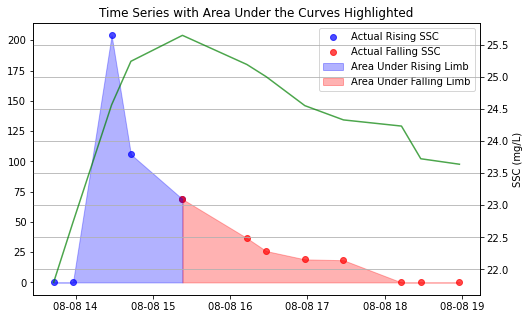

In [101]:
plt.figure(figsize=(8, 5))
# Plot actual SSC for rising and falling limbs
plt.scatter(time_rising, SSC_rising, color='blue', label='Actual Rising SSC', alpha=0.7)
plt.scatter(time_falling, SSC_falling, color='red', label='Actual Falling SSC', alpha=0.7)
# Highlight the areas under the curve using fill_between
plt.fill_between(time_rising, SSC_rising, color='blue', alpha=0.3, label='Area Under Rising Limb')
plt.fill_between(time_falling, SSC_falling, color='red', alpha=0.3, label='Area Under Falling Limb')
# Plot water depth in another axis
plt.legend()
ax2 = plt.gca().twinx()
plt.plot(time, depth, color='green', label='Water Depth', alpha=0.7)
# Labels and legend
plt.xlabel("Time")
plt.ylabel("SSC (mg/L)")
plt.title("Time Series with Area Under the Curves Highlighted")
#plt.legend()
plt.grid(True)
# Show the plot
plt.show()

In [102]:
# calculate the areas 
area_rising = trapz2((SSC_rising), time_rising)
area_falling = trapz2((SSC_falling), time_falling)

# Calculate hysteresis index
HI = area_rising / area_falling

print(f"Area under rising limb: {area_rising}")
print(f"Area under falling limb: {area_falling}")
print(f"Hysteresis Index (HI): {HI:.4f}")

Area under rising limb: 532557.0
Area under falling limb: 285304.5
Hysteresis Index (HI): 1.8666


In [104]:
# using regular np.trapz 
area_rising_trapz = np.trapz((SSC_rising), time_rising)
area_falling_trapz = np.trapz((SSC_falling), time_falling)

# Cclculate hysteresis index
HI_trapz = area_rising_trapz / area_falling_trapz

print(f"Area under rising limb: {area_rising_trapz}")
print(f"Area under falling limb: {area_falling_trapz}")
print(f"Hysteresis Index (HI) using np.trapz: {HI_trapz:.4f}")

Area under rising limb: 532557000000000 nanoseconds
Area under falling limb: 285304499999999 nanoseconds
Hysteresis Index (HI) using np.trapz: 1.8666


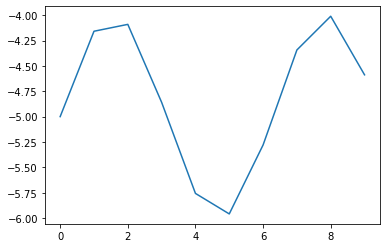

Area using trapz2: 23.71843270277746


In [118]:
## Testing the trapz2 function and compare to np.trapz
# creating variables
x0 = np.arange(0,10)
y0 = -5 + np.sin(x0)

# just checking
plt.plot(x0, y0)
plt.show()

area = trapz2(x0, y0)
print(f"Area using trapz2: {area}")

In [119]:
trapz_area = np.trapz(x0, y0)
print(f"Area using np.trapz: {trapz_area}")

Area using np.trapz: 1.959916127689307
